# Overview
******
Pneumonia is an infection in one or both lungs. The infection causes inflammation in the air sacs in your lungs, which are called **alveoli**. The alveoli fill with fluid or pus, making it difficult to breathe.

![Pneumonia Inflammation](https://www.physio-pedia.com/images/9/94/Pneumonia_Inflammation.jpg)


Doctors or radiologiests conduct a physical exam and use **CXR**(chest x-ray) to examin and detect pneumonia. In CXR it shows opacity in the reagion.

![Pneumonia CXRs](https://ars.els-cdn.com/content/image/1-s2.0-S0092867418301545-figs6_lrg.jpg)


* There are multiple causes of opacity n CXR other than pneumonia like;
    * fluid overload (pulmonary edema)
    * bleeding
    * volume loss (atelectasis or collapse)
    * lung cancer
    * post-radiation or surgical changes
    * Outside of the lungs, fluid in the pleural space (pleural effusion) 

A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR.



Pneumonia opacity can occour in different reagions of chest and the opacity can be of different kinds. This makes it the problem of detection(regression) as well as recognition(classification). For such purpose we can think of using the pre-existing models like 'Faster R-CNN' or 'Yolo'.

![Types and Regions](http://adigaskell.org/wp-content/uploads/2017/11/pneumonia-xray.jpg)



### Importing all the python Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import math
import cv2
import seaborn as sns
import tensorflow as tf

# To calculate accuracy measures and confusion matrix
from sklearn import metrics
# To get Recall and precision values
from sklearn.metrics import classification_report

# !pip install -q pydicom
# After installing pydicom. This is needed to load .dcm files
import pydicom
import pydicom as dcm
from pydicom import dcmread

from matplotlib import pyplot
import matplotlib.patches as patches

from skimage import measure
from skimage.transform import resize

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input


#### Setting up project path

In [ ]:
# Load train set image metadata
dataDirPath = '../input/rsna-pneumonia-detection-challenge/'

Train_Image_path = dataDirPath + 'stage_2_train_images'

SAVED_FILES_ROOT = '../input/reportfiles/'
RES_FILES_ROOT = '../input/resreportfiles/'

### Function definations

#### Function to load the metadata from images

In [ ]:
class ImageMetadata():
    """Structure to hold image metadata

    Arguments:
        setName -- name of the data set

        file -- file name
    """
    
    def __init__(self, setName, file):
        # print(name, file)
        # dataset name(train or test)
        self.setName = setName
        # image file name
        self.file = file

    def __repr__(self):
        return self.imagePath()

    def imagePath(self):
        return os.path.join(self.setName, self.file) 
    

# function to load image metadada   
def loadImageMetadata(dataSetName):
    """Load image file names from the images from dataset

    Arguments:
        dataSetName -- path of the data set folder
    """
    imageMetadata = []
    for f in os.listdir(dataSetName):
        # Check file extension. Allow only .dcm files.
        ext = os.path.splitext(f)[1]
        if ext == '.dcm' :
            imageMetadata.append(ImageMetadata(dataSetName, f))
            
    # Return an array of filenames
    return np.array(imageMetadata)

#### Functions to load image and patientId(file name) from the given path

In [ ]:
def loadImage(path):
    """Load image from the path 

    Arguments:
        path -- path of the image
    """
    img = pydicom.dcmread(path)
    
    # Return image
    return img


def getImgId(imgPath) :
    """Get image name which is patientId from the given image path 

    Arguments:
        imgPath -- path of the image
    """
    
    # Return patientId 
    return str(imgPath).split(".dcm")[0].split("/")[4]

#### Getting Metadata Information

In [ ]:
trainSetImageMetadata = loadImageMetadata(Train_Image_path)

print("trainSetImageMetadata.shape : ", trainSetImageMetadata.shape)

print("Sample image path : ", trainSetImageMetadata[0])

#### Insights from Metadata

There are 26684 images in the Training data
These are DICOM Images which has pixel information as well as several tags added to it like patientid, age,gender etc.

#### Loaging a sample Image

In [ ]:
# with given index
imgIndex = 4
imgPath = trainSetImageMetadata[imgIndex]
imgPath = imgPath.imagePath()
imgData = loadImage(imgPath)

pyplot.imshow(imgData.pixel_array, cmap=pyplot.cm.bone)

#### Preparing Dataset with patient id and respective image paths

In [ ]:
trainSetImageMetadata_df = pd.DataFrame(trainSetImageMetadata, columns=["Path"])
trainSetImageMetadata_df.head(2)

imageIdPaths = pd.DataFrame(columns=["patientId", "imgPath"])
imageIdPaths["patientId"] = trainSetImageMetadata_df["Path"].apply(getImgId)
imageIdPaths["imgPath"] = trainSetImageMetadata_df["Path"]

print("imageIdPaths", imageIdPaths.shape)
imageIdPaths.head(2)

# Exploratory Data Analysis on Train Labels and Detail Info CSV data sets

**Analyzing Detailed Classes CSV file**

Step 1 -> Define and read the Detail_Info CSV File 

In [ ]:
classesPath =  dataDirPath + 'stage_2_detailed_class_info.csv'

detailedClasses = pd.read_csv(classesPath)

detailedClasses.head(2)

Step 2 -> Check for Missing Values


In [ ]:
detailedClasses.isna().apply(pd.value_counts)

No Missing Values found

Step 3 -> Checking the shape of data frame

In [ ]:
print("detailedClasses.shape : ", detailedClasses.shape)

# File has 30227 rows and 2 columns - PatientID & Class

Step 3 -> Checking Unique Patients

In [ ]:
print("Unique patientIds : ", detailedClasses['patientId'].nunique())

Total number of unique patients in data - 26684

**Observation - As we have total 30227 records and out of that 26684 are unique records, this shows presence of multiple records for some patients**

Step 4 -> Checking unique Classes

In [ ]:
print("Unique patientIds : ", detailedClasses['class'].nunique(), )

print(detailedClasses['class'].unique)

3 Unique classes observed 
1 - No Lung Opacity/Not Normal,
2 - Normal,
3 - Lung Opacity

In [ ]:
sns.countplot(x="class",hue="class",data=detailedClasses)

#### Analyzing Train Lables Dataset

Step 1 -> Reading the data 

In [ ]:
labelsPath = dataDirPath + 'stage_2_train_labels.csv'

trainLabels = pd.read_csv(labelsPath)

trainLabels.head(2)

Step 2 -> Checking the missing values if any

In [ ]:
trainLabels.isna().apply(pd.value_counts)

#### Observation - For around 20672 patients Bounding box cordinates not available where as for 9555 patients its avaialable

In [ ]:
trainLabels[trainLabels['Target']==0].head(2)

Few records have observed with missing values in **x, y, width** and **height** coulmn, but no missing values observed in **patientId** and **Target**.

Also this is observed such missing columns are present for those records with **Target** as '0'.

**x, y, width** and **height** columns have the information for bounding boxes in Images where Penumonia is detected.

**Explaination on missing values - These are not the missing values instead it is expected not to have Bounding Box co-ordinates for those images where Pneumonia is not detected (Target - '0')**

Hence concluding there are no missing values in this dataset as well

Step 3 -> Checking unique Patients

In [ ]:
print("Unique patientIds : ", trainLabels['patientId'].nunique(), )

Total Unique patients found - 26684

This is same as the number of patients in Detailed CSV sheet hence both sheets share the information for same patients

Step 4 -> Checkin unqiue Targets

In [ ]:
print("Unique patientIds : ", trainLabels['Target'].nunique(), )

print("Unique patientIds : ", trainLabels['Target'].unique(), )

Trail label has only 2 target variables [0 & 1] 

**Conclusion - In Train labels only two target variables are present 0 & 1, where as in Detailed_Info sheet we have 3 classes.**

**As we have 3 Classes in Detailed_Info dataset and 2 Target Variables in Train_Labels, concatenating to get better insight into the data**

Step 1 -> Sorting both the datasets based on patientId

In [ ]:
trainLabels.sort_values("patientId", inplace=True)
detailedClasses.sort_values("patientId", inplace=True)

Step 2 -> Concatenating the data

* To get the Target and classes into one dataframe

In [ ]:
Combined_Data = pd.concat([trainLabels, detailedClasses["class"]], axis=1, sort=False)
Combined_Data.head(3)

**Validating the concatenation results**

In [ ]:
Combined_Data.shape

In [ ]:
Combined_Data.isna().apply(pd.value_counts)

In [ ]:
Combined_Data[Combined_Data["Target"] == 1].isna().apply(pd.value_counts)

In [ ]:
Combined_Data[Combined_Data["Target"] == 0].isna().apply(pd.value_counts)

In [ ]:
Combined_Data[Combined_Data["class"] == "Lung Opacity"].isna().apply(pd.value_counts)

From Above Analysis our concatenated data is correct

## Prepare data for training


Step 1 -> 
* Convert data to only two classes, 'Normal' and 'Lung Opacity'
* Splitting the data in three parts, train, validation and test sets.
* Replace all 'NaN' values to zero(0)


In [ ]:
# Conver data to only two classes, 'Normal' and 'Lung Opacity'
Combined_Data["class"].replace("No Lung Opacity / Not Normal", "Normal", inplace=True)
Combined_Data.head(3)

In [ ]:

train_CombinedData = Combined_Data[0:15000]
validate_CombinedData = Combined_Data[15000:25000]
test_CombinedData = Combined_Data[25000:30227]

print("train_CombinedData.shape : ", train_CombinedData.shape)
print("validate_CombinedData.shape : ", validate_CombinedData.shape)
print("test_CombinedData.shape : ", test_CombinedData.shape)

print("\nunique train patients : ", train_CombinedData["patientId"].nunique())
print("unique validate patients : ", validate_CombinedData["patientId"].nunique())
print("unique test patients : ", test_CombinedData["patientId"].nunique())

print("\nTotal unique patients : ", imageIdPaths["patientId"].nunique())
print("Total of unique train and test : ", train_CombinedData["patientId"].nunique() + validate_CombinedData["patientId"].nunique() + test_CombinedData["patientId"].nunique())

print("\nLast from train set : ", train_CombinedData.iloc[14999]["patientId"])
print("First from validate set : ", validate_CombinedData.iloc[0]["patientId"])
print("\nLast from validate set : ", validate_CombinedData.iloc[9999]["patientId"])
print("First from test set : ", test_CombinedData.iloc[0]["patientId"])

# Set all NaN values to 0 in train and test data sets. While training NaN will not have any meaning.
#    * x, y, width and hight values as zero(0) means no bounding box.
train_CombinedData.fillna(0, inplace=True)
validate_CombinedData.fillna(0, inplace=True)
test_CombinedData.fillna(0, inplace=True)

In [ ]:
imageIdPaths.sort_values("patientId", inplace=True)

train_imageIdPaths = imageIdPaths[0:13163]
validate_imageIdPaths = imageIdPaths[13163:21764]
test_imageIdPaths = imageIdPaths[21764:26684]

print("train_imageIdPaths.shape : ", train_imageIdPaths.shape)
print("validate_imageIdPaths.shape : ", validate_imageIdPaths.shape)
print("test_imageIdPaths.shape : ", test_imageIdPaths.shape)

print("\nunique train patients : ", train_imageIdPaths["patientId"].nunique())
print("unique validate patients : ", validate_imageIdPaths["patientId"].nunique())
print("unique test patients : ", test_imageIdPaths["patientId"].nunique())

print("\nTotal unique patients : ", imageIdPaths["patientId"].nunique())
print("Total of unique train and test : ", train_imageIdPaths["patientId"].nunique() + validate_imageIdPaths["patientId"].nunique() + test_imageIdPaths["patientId"].nunique())

print("\nLast from train set : ", train_imageIdPaths.iloc[13162]["patientId"])
print("First from validate set : ", validate_imageIdPaths.iloc[0]["patientId"])
print("Last from validate set : ", validate_imageIdPaths.iloc[8600]["patientId"])
print("First from test set : ", test_imageIdPaths.iloc[0]["patientId"])

In [ ]:
sns.countplot(x="Target",hue="class",data=train_CombinedData)

In [ ]:
sns.countplot(x="Target",hue="class",data=validate_CombinedData)

In [ ]:
sns.countplot(x="Target",hue="class",data=test_CombinedData)

* Observation
    * train, validation and test sets are not well balanced. 
    * Images with 'Lung Opacity' are less in proportion in all these sets.

# Build UNet

### Constants

In [ ]:
IMAGE_SIZE = 224

IMG_WIDTH = 1024
IMG_HEIGHT = 1024

TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

ALPHA = 1.0

### Function and Class definations

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    """Get Intersection over Union(IoU) ratio from ground truth and predicted masks.
    Arguments:
        y_true -- ground truth mask
        
        y_pred -- predicted mask
    """
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# mean iou as a metric
def mean_iou(y_true, y_pred):
    """Get mean Intersection over Union(IoU) ratio from ground truth and predicted masks.
    Arguments:
        y_true -- ground truth mask
        
        y_pred -- predicted mask
    """
    y_pred = tf.round(y_pred)    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1]) 
    union = tf.reduce_sum(y_true, axis=[1]) + tf.reduce_sum(y_pred, axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
def iouFromCoords(boxA, boxB) :
    """Get Intersection over Union(IoU) ratio from ground truth and predicted box coordinates.
    Arguments:
        boxA -- ground truth mask
        
        boxB -- predicted mask
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:

def showMaskedImage(_imageSet, _maskSet, _index) :
    """To show image with imposing mask on it for the given index, form the given sets of images and masks.
    Arguments:
        _imageSet -- set of images
        
        _maskSet -- set of masks
        
        _index -- index of a set/collection
    """
    maskImage = _imageSet[_index]

    #pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)
    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)


In [ ]:

class UNetTrainGenerator(Sequence):
    """Generator class to get data batches for training model. Extends Sequence class.
        
    Arguments:
        _imageIdPaths -- dataframe having patientId and image paths to load image for the patientId
        
        _CombinedData -- dataframe having patientId, image labels, target and class values combined together
        
        idx -- index of a batch
    """
    def __init__(self, _imageIdPaths, _CombinedData):       
        self.pids = _CombinedData["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _CombinedData[["x", "y", "width", "height"]].to_numpy()
        # Resize Bounding box
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / TRAIN_BATCH_SIZE)
    

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * TRAIN_BATCH_SIZE:(idx + 1) * TRAIN_BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * TRAIN_BATCH_SIZE:(idx + 1) * TRAIN_BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path)) # Read image
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    
            #print("batch_images[_indx] shape :", batch_images[_indx][:,:,0].shape)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1
            
        # Returns images and ground truth masks for training
        return batch_images, batch_masks

In [ ]:
# Generator for Predicting/Testing model
class UNetTestGenerator(Sequence):
    """Generator class to get data batches for testing model. Used to get batches of test data used for getting predictions.
        
    Arguments:
        _imageIdPaths -- dataframe having patientId and image paths to load image for the patientId
        
        _CombinedData -- dataframe having patientId, image labels, target and class values combined together
        
        idx -- index of a batch
    """
    def __init__(self, _imageIdPaths, _CombinedData):       
        self.pids = _CombinedData["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _CombinedData[["x", "y", "width", "height", "Target"]].to_numpy() #for (1024, 1024)
        self.classes = _CombinedData["class"]
        # Resize Bounding box
        self.coordsOrig = self.coords #for (1024, 1024)
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH   #for (224, 224)
        

    def __len__(self):
        # Returns total number of batches
        return math.ceil(len(self.coords) / TEST_BATCH_SIZE)
    

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image coords for (224, 224)
        batch_coordsOrig = self.coordsOrig[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image coords for (1024, 1024)
        batch_pids = self.pids[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image pids    
        batch_classes = self.classes[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image classes           
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path)) # Read image
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA) #(224, 224)
            #resized_img = cv2.resize(img[200:824, 200:824], dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    
            #print("batch_images[_indx] shape :", batch_images[_indx][:,:,0].shape)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            target = int(batch_coords[_indx, 4])
            
            batch_coords[_indx, 0] = x
            batch_coords[_indx, 1] = y 
            batch_coords[_indx, 2] = width 
            batch_coords[_indx, 3] = height    
            batch_coords[_indx, 4] = target 
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        # Returns images, ground truth masks, patientIds, resized-coordinates, class targets and ground truth coordinates/lables.   
        return batch_images, batch_masks, batch_pids, batch_coords, batch_classes, batch_coordsOrig  #for (224, 224) and (1024, 1024)

In [ ]:

def create_UNetModel(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [ ]:

def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    """Function to create part of UNet architecture with ResNet50. 
    Adds convolutional layer followed by Batch Normalization and Activation layers.
        
    Arguments:
        prevlayer -- previous layer of the convolution block
        
        filters -- number of filters for convolution
        
        prefix -- prefix for the layer name
        
        strides -- convolution stride. Default is 1x1.
    """
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    
    # Returns the built layers of the block.
    return conv

* Trained all layers of ResNet50 starting with initial pre-trained  weights on ‘imagenet’. All U-Net decoder layer weights are trained from zero. 
* We have image dataset very different from the ‘imagenet’. Here identifying features/segments for pattern is important, than finding an object. Hence decided to train all the weights, starting with pre-loaded ‘imagenet’ weights.


In [ ]:

def create_ResNetUNetModel(trainable=True):
    """Function to create UNet architecture with ResNet50.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    resnetLayers = ResNet50(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False) # Load pre-trained Resnet
    # Top layer is last layer of the model

    for layer in resnetLayers.layers:
        layer.trainable = trainable

    # Add all the UNet layers here
    convLayer_112by112 = resnetLayers.get_layer("conv1_relu").output
    convLayer_56by56 = resnetLayers.get_layer("conv2_block3_out").output # conv2_block3_2_relu
    convLayer_28by28 = resnetLayers.get_layer("conv3_block4_out").output # conv3_block4_2_relu
    convLayer_14by14 = resnetLayers.get_layer("conv4_block6_out").output # conv4_block6_2_relu
    convLayer_7by7 = resnetLayers.get_layer("conv5_block3_out").output # conv5_block3_2_relu
    # The last layer of resnet model(conv5_block3_out) is of dimensions (7x7x2048)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNet
    # concatinate with the original image layer of the same size from ResNet50
    up14by14 = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    upConvLayer_14by14 = conv_block_simple(up14by14, 256, "upConvLayer_14by14_1")
    upConvLayer_14by14 = conv_block_simple(upConvLayer_14by14, 256, "upConvLayer_14by14_2")
    
    up28by28 = Concatenate()([UpSampling2D()(upConvLayer_14by14), convLayer_28by28])
    upConvLayer_28by28 = conv_block_simple(up28by28, 256, "upConvLayer_28by28_1")
    upConvLayer_28by28 = conv_block_simple(upConvLayer_28by28, 256, "upConvLayer_28by28_2")
     
    up56by56 = Concatenate()([UpSampling2D()(upConvLayer_28by28), convLayer_56by56])
    upConvLayer_56by56 = conv_block_simple(up56by56, 256, "upConvLayer_56by56_1")
    upConvLayer_56by56 = conv_block_simple(upConvLayer_56by56, 256, "upConvLayer_56by56_2")    
    
    up112by112 = Concatenate()([UpSampling2D()(upConvLayer_56by56), convLayer_112by112])
    upConvLayer_112by112 = conv_block_simple(up112by112, 256, "upConvLayer_112by112_1")
    upConvLayer_112by112 = conv_block_simple(upConvLayer_112by112, 256, "upConvLayer_112by112_2")   
    
    up224by224 = UpSampling2D(name="unet_last")(upConvLayer_112by112) # upsample to 224x224
    upConvLayer_224by224 = conv_block_simple(up224by224, 256, "upConvLayer_224by224_1")
    upConvLayer_224by224 = conv_block_simple(upConvLayer_224by224, 256, "upConvLayer_224by224_2")   

    # Add classification layer
    upConvLayer_224by224 = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(upConvLayer_224by224)
    upConvLayer_224by224 = Reshape((IMAGE_SIZE, IMAGE_SIZE))(upConvLayer_224by224) 

    return Model(inputs=resnetLayers.input, outputs=upConvLayer_224by224)

In [ ]:

def showConfusionMatrixFromFile(report30IOU) :
    """To show Confusion Matrix and Classification report from given dataframe.
        
    Arguments:
        report30IOU -- dataframe having target and prediction columns.
    """
    report30IOU.fillna(0, inplace=True) # set NA IOU values to zero
    # Get Targets and Predictions
    y_30_test = report30IOU["Target"]
    y_30_predicted = report30IOU["predTarget"]
    print("Predictions above 30% IOU :\n")
    print("Confusion Matrix:- \n", metrics.confusion_matrix(y_30_test, y_30_predicted), "\n")
    print("Classification Report:- \n", metrics.classification_report(y_30_test, y_30_predicted))
    
    
def showConfusionMatrixFromYs(y_test, y_predicted) :
    """To show Confusion Matrix and Classification report from given dataframes y_test and y_predicted.
        
    Arguments:
        y_test -- 1D dataframe having target values.
        y_predicted -- 1D dataframe having predicted values.
    """
    print("Predictions above 30% IOU :\n")
    print("Confusion Matrix:- \n", metrics.confusion_matrix(y_test, y_predicted), "\n")
    print("Classification Report:- \n", metrics.classification_report(y_test, y_predicted))

In [ ]:

# Funstion to plot history curves
def plotHistory(_HISTORY_FILE) :
    """To plot history curves for training and validation losses
        
    Arguments:
        _HISTORY_FILE -- training history file name with path.
    """
    unetSavedHistory = np.load(_HISTORY_FILE, allow_pickle=True).item()
    unetSavedHistoryDF = pd.DataFrame(unetSavedHistory)
    
    # list data in history
    # summarize history for loss
    pyplot.plot(unetSavedHistoryDF['loss'])
    pyplot.plot(unetSavedHistoryDF['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='best')
    pyplot.show()
    # summarize history for mean IOU
    pyplot.plot(unetSavedHistoryDF['mean_iou'])
    pyplot.plot(unetSavedHistoryDF['val_mean_iou'])
    pyplot.plot(unetSavedHistoryDF['lr'])
    pyplot.title('model IOU and Leraning rate')
    pyplot.ylabel('IOU and LR')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation', 'Lerning Rate'], loc='best')
    pyplot.show()


In [ ]:

def predictBatches(_test_CombinedData, _test_imageIdPaths, _UNetModel) :
    """Method to predict test data set and save the submission report into a csv file.
        
    Arguments:
        _test_CombinedData -- test set dataframe having patientId, image labels, target and class values combined together

        _imageIdPaths -- test set dataframe having patientId and image paths to load image for the patientId
        
        _UNetModel -- UNet model with trainined weights used for predicting test data
    """
    print('Number of Test Samples :', _test_CombinedData["patientId"].nunique()) # about 20% of the dataset
    
    # create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdPaths, _test_CombinedData) #for (224, 224)
    
    # create submission dafa frame with column names
    submissionDF = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'x_pred', 'y_pred', 'width_pred', 
                                         'height_pred', 'predTarget', 'iou', 'class_pred'])
    dfIndex = 0
    iouThreshold = 0.3 # IoU above 30%

    # loop through testset
    # for batches from testUNetDataGen
    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:    #for (224, 224)
        print(".", end = '')    
        
        # predict batch of images
        batchPreds = _UNetModel.predict(batchImages)    #for (224, 224)

        prevPid = ""
        # loop through batch
        for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig):   #for (224, 224)

            if prevPid != pid :
                prevPid = pid

                # resize predicted mask
                pred = resize(pred, (1024, 1024), mode='reflect')   #for (1024, 1024)
                # recompute coords for resized pred
                coords = coordsOrig   #for (1024, 1024)

                # threshold predicted mask
                strongPred = pred[:, :] > 0.5   

                # apply connected components
                strongPred = measure.label(strongPred)

                loopIndx = 0
                # collect all reagions for the prediction
                iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                for region in measure.regionprops(strongPred) :
                    # retrieve x, y, height and width
                    y, x, y2, x2 = region.bbox
                    height = y2 - y
                    width = x2 - x
                    # Get IOUs
                    coordsXYs = np.array([coords[0], coords[1], coords[2]+coords[0], coords[3]+coords[1]])
                    regionXYs = np.array([x, y, x2, y2])
                    IOU = iouFromCoords(coordsXYs, regionXYs)
                    #print("IOU ", IOU)
                    iouCoordsRow = [IOU, x, y, width, height]
                    iouCoordsDF.loc[loopIndx] = iouCoordsRow
                    loopIndx = loopIndx + 1

                GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass] # ground truth data 
                prevGTDFRow = []
                # Get top 2 predictions based on IOU 
                iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                predIOUCoordCount = 0
                # If predictions exist
                if len(iouCoordsDF) > 0 :
                    for predIOUCoordIdx in (0, len(iouCoordsDF)-1) :
                        if iouCoordsDF.loc[predIOUCoordIdx]["iou"] > iouThreshold :
                            # add row with ground truth and prediction values to data frame    
                            submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4],
                                               gtClass, int(iouCoordsDF.loc[predIOUCoordIdx]["x"]), int(iouCoordsDF.loc[predIOUCoordIdx]["y"]), 
                                               int(iouCoordsDF.loc[predIOUCoordIdx]["width"]), int(iouCoordsDF.loc[predIOUCoordIdx]["height"]), 
                                               1, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Lung Opacity"]
                            if predIOUCoordCount < 2 :
                                if GTDFRow != prevGTDFRow : 
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex = dfIndex + 1 
                                    predIOUCoordCount = predIOUCoordCount + 1
                                    prevGTDFRow = GTDFRow
                            else :
                                break;
                        else : # Normal if IOU below threshold
                            # add row with ground truth and prediction values to data frame
                            if GTDFRow != prevGTDFRow :  
                                submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                                   gtClass, 0, 0, 0, 0, 0, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Normal"]
                                submissionDF.loc[dfIndex] = submissionDFRow
                                dfIndex = dfIndex + 1  
                                prevGTDFRow = GTDFRow
                                break;
                            # end of if
                        # end of if
                    # end of for

                else : # else of If predictions exist. Normal if no predictions
                    # add row with ground truth and prediction values to data frame
                    submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                       gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"]
                    submissionDF.loc[dfIndex] = submissionDFRow
                    dfIndex = dfIndex + 1      

        # To stop at certain count. Used to debug code.
#             if len(submissionDF) >= 5 :
#                 break

    # save dictionary as csv file
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)

In [ ]:

def visualizePredictions(_predReportDF, _topNum) :
    """Method to visualize predictions by displaying ground truth and predicted bounding boxes.
        
    Arguments:
        _predReportDF -- dataframe having target and prediction coordinate columns; patientId and IoUs.

        _topNum -- number indicating the count of top predictions to be visualized.
    """
    # Sort on IOU to get higher IOUs on top
    _predReportDF.sort_values("iou", ascending=False, inplace=True)
    # Get patientIds
    topPids = _predReportDF["patientId"].head(_topNum)
    topPidsAry = np.array(topPids)
    # Get IOUs
    topIOUs = _predReportDF["iou"].head(_topNum)
    topIOUsAry = np.array(topIOUs)

    # To get ground truth images for top IOU scored pids
    imageCollc = np.zeros((_topNum, IMG_WIDTH, IMG_HEIGHT), np.float32) # (1024, 1024)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    gtCoordCollc = _predReportDF[["x", "y", "width", "height"]].to_numpy()  # (1024, 1024)
    # To get ground truth masks
    gtMaskCollc  = np.zeros((_topNum, IMG_WIDTH, IMG_HEIGHT), np.int) # (1024, 1024)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    predCoordCollc = _predReportDF[["x_pred", "y_pred", "width_pred", "height_pred"]].to_numpy()  # (1024, 1024)
    # To get ground truth masks
    predMaskCollc  = np.zeros((_topNum, IMG_WIDTH, IMG_HEIGHT), np.int)

    # Get ground truth and prediction masks
    for indx in range(0, _topNum) :
        # Get images
        path = test_imageIdPaths[test_imageIdPaths["patientId"] == topPidsAry[indx]]["imgPath"].array[0]
        imgData = loadImage(str(path)) # Read image
        img = imgData.pixel_array
        imageCollc[indx][:,:] = preprocess_input(np.array(img[:,:], dtype=np.float32)) # Convert to float32 array

        # prepare ground truth masks
        x = int(gtCoordCollc[indx, 0])
        y = int(gtCoordCollc[indx, 1])
        width = int(gtCoordCollc[indx, 2])
        height = int(gtCoordCollc[indx, 3])
        gtMaskCollc[indx][y:y+height, x:x+width] = 1   # (1024, 1024)

        # prepare predicted masks
        x_pred = int(predCoordCollc[indx, 0])
        y_pred = int(predCoordCollc[indx, 1])
        width_pred = int(predCoordCollc[indx, 2])
        height_pred = int(predCoordCollc[indx, 3])
        predMaskCollc[indx][y_pred:y_pred+height_pred, x_pred:x_pred+width_pred] = 1   # (1024, 1024)
        
    # Show images and bounding boxes
    imageArea, axesArry = pyplot.subplots(int(_topNum/2), 2, figsize=(18,18))
    axesArry = axesArry.ravel()
    for axidx in range(0, _topNum) :
        axesArry[axidx].imshow(imageCollc[axidx][:, :], cmap=pyplot.cm.bone)

        gtComp = gtMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        gtComp = measure.label(gtComp)
        # apply ground truth bounding boxes
        for region in measure.regionprops(gtComp):
            # retrieve x, y, height and width
            y1, x1, y2, x2 = region.bbox
            heightReg = y2 - y1
            widthReg = x2 - x1
            axesArry[axidx].add_patch(patches.Rectangle((x1, y1), widthReg, heightReg, linewidth=1, edgecolor='r', 
                                                        facecolor='none'))

        predComp = predMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        predComp = measure.label(predComp)
        # apply predicted bounding boxes
        for region_pred in measure.regionprops(predComp):
            # retrieve x, y, height and width
            y1_pred, x1_pred, y2_pred, x2_pred = region_pred.bbox
            heightReg_pred = y2_pred - y1_pred
            widthReg_pred = x2_pred - x1_pred
            axesArry[axidx].add_patch(patches.Rectangle((x1_pred, y1_pred), widthReg_pred, heightReg_pred, linewidth=1, edgecolor='b', 
                                                        facecolor='none'))
            axesArry[axidx].set_title('IOU : '+str(topIOUsAry[axidx]))
    # Show subplots
    pyplot.show()

### Create Generator instances for Train and Validation datasets

* These are further used in fit() method while training the model.

In [ ]:
trainUNetDataGen = UNetTrainGenerator(train_imageIdPaths, train_CombinedData)
validateUNetDataGen = UNetTrainGenerator(validate_imageIdPaths, validate_CombinedData)

print(len(trainUNetDataGen), "# of iterations in one train epoch")
print(len(validateUNetDataGen), "# of iterations in one validate epoch")

#### visualize sample image with a mask to verify train generator instance 

In [ ]:
imageSet0 = trainUNetDataGen[0][0]
maskSet0 = trainUNetDataGen[0][1]    
showMaskedImage(imageSet0, maskSet0, 5)

## Build UNet with MobileNet

* We start with a simple UNet architecture using MobileNet layers pretrained with 'imagenet' weights.

#### Train the Model

In [ ]:
trainUnetModel = False

EPOCHS = 3
WEIGHTS_FILE = SAVED_FILES_ROOT + "unetModel-0.73.h5"

adamOptimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint("unetModel-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping( monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

UNetModel = create_UNetModel()
UNetModel.compile(loss=iou_loss, optimizer=adamOptimizer, metrics=[mean_iou]) 

UNetModel.load_weights(WEIGHTS_FILE) # train with saved weights

if trainUnetModel==True :
    # Make layers trainable
    for layer in UNetModel.layers:
        layer.trainable = True

    hist = UNetModel.fit_generator(generator=trainUNetDataGen,
                        epochs=EPOCHS,
                        validation_data=validateUNetDataGen,
                        callbacks=[checkpoint, reduce_lr, stop],
                        shuffle=True,
                        verbose=1)
    
    unet_history = np.array(hist.history)
    np.save("unetTrainHist-3", unet_history, allow_pickle=True)
    

#### Plot training history curves

In [ ]:
HISTORY_FILE = SAVED_FILES_ROOT + "unetTrainHist.npy"
plotHistory(HISTORY_FILE)

#### Visualize the UNet architecture

In [ ]:
pltUtil.plot_model(UNetModel,
                    to_file="UnetModel.png",
                    show_shapes=True,
                    show_layer_names=True,
                    expand_nested=False,
                    dpi=70)

In [ ]:
# Check sample ground truth masked image and predicted masked image 
imageSet0 = trainUNetDataGen[0][0]
maskSet0 = trainUNetDataGen[0][1]
print("Ground Truth Box/Mask")
showMaskedImage(imageSet0, maskSet0, 5)

In [ ]:
predMasks = UNetModel.predict(imageSet0)
print("Predicted Box/Mask")
showMaskedImage(imageSet0, predMasks, 5)

#### Predict the Test data set

In [ ]:
predictUnetModel = False

if predictUnetModel == True :
    y_test, y_predicted = predictBatches(test_CombinedData, test_imageIdPaths, UNetModel)

#### Show Confusion Matrix and Classification Report

In [ ]:
REPORT_30_FILE = SAVED_FILES_ROOT + "submission_30.csv"
report30IOU = pd.read_csv(REPORT_30_FILE)
showConfusionMatrixFromFile(report30IOU)


### Top predicted masks with bounding boxes

* Lets see some of the the top predictions
* Red boxes are ground truth
* Blue boxes are predictions

In [ ]:
topNum = 6 # provide even number
visualizePredictions(report30IOU, topNum)

## Build UNet with ResNet50

* We started with a simple UNet architecture using MobileNet layers pretrained with 'imagenet' weights.

* Now we do advancement to it by using ResNet50 layers  pretrained with 'imagenet' weights to build the UNet architecture.

#### Train the Model

In [ ]:
trainResnetUnetModel = False
EPOCHS = 1
WEIGHTS_FILE = RES_FILES_ROOT + "resnetModel-0.78.h5"

res_adamOptimizer = Adam(lr=1e-1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
res_checkpoint = ModelCheckpoint("resnetModel-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=False,
                             save_weights_only=True, mode="min", period=1)
res_stop = EarlyStopping( monitor="loss", patience=5, mode="min")
res_reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="min")

ResNetUNetModel = create_ResNetUNetModel()
ResNetUNetModel.compile(loss=iou_loss, optimizer=res_adamOptimizer, metrics=[mean_iou]) 

ResNetUNetModel.load_weights(WEIGHTS_FILE)

if trainResnetUnetModel==True :
    # Make layers trainable
    for layer in ResNetUNetModel.layers:
        layer.trainable = True

    reshist = ResNetUNetModel.fit_generator(generator=trainUNetDataGen,
                        epochs=EPOCHS,
                        validation_data=validateUNetDataGen,
                        callbacks=[res_checkpoint, res_reduce_lr, res_stop],
                        shuffle=True,
                        verbose=1)
    
    resnetUnet_history = np.array(reshist.history)
    np.save("resnetUnetTrainHist", resnetUnet_history, allow_pickle=True)

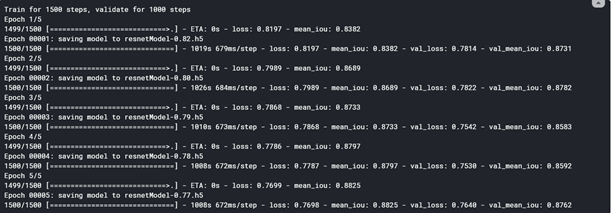

**Providing a screenshot here of the training process output. 
Further we are loading the best saved weights for prediction.**

In [ ]:
pltUtil.plot_model(ResNetUNetModel,
                    to_file="resnetUnetModel.png",
                    show_shapes=True,
                    show_layer_names=True,
                    expand_nested=False,
                    dpi=70)

#### Observe ResNetUNet Model training history
* See how loss and mean-IoU improved over the epochs

In [ ]:
RES_HISTORY_FILE = RES_FILES_ROOT + "resnetUnetTrainHist.npy"
plotHistory(RES_HISTORY_FILE)

#### After 4th epoch we see that the validation loss getting increased which indicates overfitting of the model.
* Hence we take the weights saved after 4th epoch (i.e. **‘resnetModel-0.78.h5’**) for performing predictions.


In [ ]:
predictResNetUNetModel = False

if predictResNetUNetModel == True :
    y_test_res, y_predicted_res = predictBatches(test_CombinedData, test_imageIdPaths, ResNetUNetModel)


#### As mentioned above we are using weights saved after 4th epoch. 
* Here we load the submission file saved with these weights and showing confusion matrix. 

In [ ]:
RESREPORT_30_FILE = RES_FILES_ROOT + "resSubmission_30_IOU_4thEpoch.csv"

if predictResNetUNetModel == True :
    showConfusionMatrixFromYs(y_test_res, y_predicted_res)
else :
    ResReport30IOU = pd.read_csv(RESREPORT_30_FILE)
    showConfusionMatrixFromFile(ResReport30IOU)


#### This Confusion matrix and Classification report are much better that that of U-Net with MobileNet.

#### Analyze Confusion matrix
* In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.
* Thought there are three classes given in the dataset, for this classification we have considered “Not Normal No Lung Opacity” class as "Normal" and reduced the problem to binary classification.
* So we are interested in predicting patients who has pneumonia, i.e. "Lung Opacity" class.
* Since we have a data imbalance considering classes, the overall accuracy is not the right measure to evaluate the model. Hence it is important to analyze confusion martix. This gives accuracy at the class level.

Lets analyze confusion martix with this interest in mind.

In actual test data;
* True Positives(TP) are;
    * 372 patients who have actually 'Lung Opacity' correctly predicted as has 'Lung Opacity'.


* True Negatives(TN) are;
    * 4214 patients who have actually 'No Lung Opacity'/'Normal' correctly predicted as 'Normal'.


* False Positives(FP) are;
    * 0 patients(No patients) who have actually 'No Lung Opacity'/'Normal' incorrectly predicted as having 'Lung Opacity'. 
    * This means there are no model mistakes in identifying 'Normal' as 'Lung Opacity'. Type-I error is zero.
    * This is a big positive point for a medical test. 
    

* False Negatives(FN) are;
    * 368 patients who have actually 'Lung Opacity' incorrectly predicted as'Normal'. 
    * These are model mistakes. 
    

#### Analyze Precision and Recall

* Precision For 'Lung Opacity' = TP/(TP+FP)
    * The above FP value impacts 'Precision' value. Hence we see 'Precision' for category '1' i.e. 'Lung Opacity' is 1 (100%). 


* Recall For 'Lung Opacity' = TP/(TP+FN) 
    * The 'Recall' value for  category '0' i.e. 'Normal' is 1 (100%).
    * The above FN value impacts 'Recall' value. There is a scope to improve the model 'Recall' value for category '1' i.e. 'Lung Opacity'.


* f1-score is harmonic mean of Precision and Recall. Ths is used when we are interested in both.
    * 'accuracy' f1-score is 93%
    * 'weighted avg' f1-score is 91%



#### Lets see some of the top predictions alongwith the bounding box IoU values.

* Red boxes are ground truths
* Blue boxes are predictions

In [ ]:
topNum = 10 # provide even number
visualizePredictions(ResReport30IOU, topNum)

*  ** Even though some of the IoU valuses are less than 80%, we observe that the ground truth boxes are completely covered within the predicted boxes. **

* **It is important to see that images with different brightness, clarity, contrast are amoung the top predictions.**

### Classification Accuracy and Error

In [ ]:
TP = 372
TN = 4214
correctPredictions = TP + TN
totalPredictions = 4954

classificationAccuracy = correctPredictions / totalPredictions * 100.0
print("Classification Accuracy :", classificationAccuracy)


FP = 0
FN = 368
incorrectPredictions = FP + FN

classificationError = incorrectPredictions / totalPredictions
print("Classification Error :", classificationError)

* Classification Accuracy is 92.57%. The model is 92.57% accurate.
* Classification Error is 7.42%.

### Confidence Interval

Rather than presenting just a single error score, a confidence interval can be calculated and presented as part of the model skill.

A confidence interval is comprised of two things:

Range:- This is the lower and upper limit on the skill that can be expected on the model.

Probability:- This is the probability that the skill of the model will fall within the range.

In general, the confidence interval for classification error can be calculated as follows:

**error +/- const * sqrt( (error * (1 - error)) / n)**

Where error is the classification error, const is a constant value that defines the chosen probability, sqrt is the square root function, and n is the number of observations (rows) used to evaluate the model. Technically, this is called the Wilson score interval.

The values for const are provided from statistics, and common values used are:

1.64 (90%)

1.96 (95%)

2.33 (98%)

2.58 (99%)


In [ ]:
chosenProbability = 1.96    # 1.96 for (95%)
numOfObservations = 4954

classificationInterval = (chosenProbability * math.sqrt(classificationError * (1 - classificationError) / numOfObservations))
print("Classification Interval :", classificationInterval)

confidenceIntervalUpper = classificationError + classificationInterval
print("Confidence Interval for classification error Upper Level:", confidenceIntervalUpper)

confidenceIntervalLower = classificationError - classificationInterval
print("Confidence Interval for classification error Lower :", confidenceIntervalLower)


* **There is a 95% likelihood that the confidence interval [0.0670, 0.0816] covers the true classification error of the model on unseen data.**
    * That means the model will give classification error between 6.70% and 8.16%; 95% of the time on unseen data, that means in production. 


*** In other words, the model will give accuracy between **91.84%**(100-8.16) and **93.3%**(100-6.70) with 95% of confidence(or 95% of the time)**

### ROC and AUC

In [ ]:

test_y = ResReport30IOU["Target"].apply(int)
predicted_y = ResReport30IOU["predTarget"].apply(int)
# IoU values are prediction probabilities. 
pred_prob_y = ResReport30IOU["iou"] # Taking float values.

import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_prob_y)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for pnuemonia classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

* 'False Positive Rate' is the total number of FP divide by 'total number of negatives' in the test set.
    * FPR = FP/N = FP/FP+TN 


* 'True Positive Rate' is the total number of TP divide by 'total number of positives' in the test set.
    * TPR = TP/TP+FN
    * This is same as 'Recall' for class 'Lung Opacity'.
    
    
* ROC curve is not affected by the imbalance(skeweness) of the classes in the dataset.
* This curve is with the different probability cutoff values for the target class.


* The curve shows non-zero value for zero FPR. This is beacuse the FP value is zero in confusion matrix. 
    * That means for any threshold on the predicted probabilities; when the FP is zero, TP is always above zero.


In [ ]:
threshold = 0.3 # The IoU threshold set to classify as "Lung Opacity"
print("Sensitivity:", tpr[thresholds > threshold][-1])
print("Specificity:", 1 - fpr[thresholds > threshold][-1])
print("AUC :", metrics.roc_auc_score(test_y, pred_prob_y))


* AUC(Area Under Curve) is the percentage of the ROC plot that is underneath the curve.
* If you randomly chose one 'Lung Opacity' and one 'Normal' observation, AUC represents the likelihood that the model will assign a higher predicted probability to the 'Lung Opacity' observation.
* This tells the power of a test which in this case is about 82%.

# Summary

* We started with exploring data and checking how clean the data is. Observed three different classes and after analysis we logically categorized them into two to build the model.

* Model selection was a challenge as both localization and classification was needed into one. After interim sumbmission we started to Build Faster R-CNN architecture. After spending a week on that we realized that for binarry classification U-Net is better and simpler than Faster R-CNN. We found that U-Net is also widely used in medical applications. Hence switched to U-Net.

* First we built siple U-Net with MobileNet. We achieved near to 90% performance on it. Further we made advancement to it by choosing ResNet50 for U-Net. It was a struggle to identify the right points from ResNet50 layers for the crossconnections to the upsampling part of the U-Net. With some experiments we built the right architecture and achieved better results near to 93%.

* Had we saved a time what we spent on building Faster R-CNN, we would have done some upsampling of the 'Lung Opacity' class using augmentations. This would have helped us improving Recall value for 'Lung Opacity' class. 

* Overall it was a great experience working on this project and we learned a lot in the journey. 